Author: Antonio Moreno Martin

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import plotly.express as px
import seaborn as sns
import xgboost as xgb
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_absolute_error

### Read and gather downloaded data

In [2]:
# Leer y gather data
input = "/Users/amm/Documents/Github/Data/Gasolina/source/Madrid_alcampo_gasolina_98_E5/"
files = glob.glob(input + '*.xls')

df = pd.concat([pd.read_excel(file) for file in files], ignore_index=True)

df['Fecha'] = pd.to_datetime(df['Fecha'])
df.sort_values(by='Fecha', inplace = True)

In [4]:
df.tail()

,Fecha,Precio
131,2022-12-01,1.639903
132,2023-01-01,1.619419
133,2023-02-01,1.648428
134,2023-03-01,1.654032
135,2023-04-01,1.650000


In [5]:

fig = px.line(df, x = 'Fecha', y = 'Precio', title = 'Gasolina 98 E5 Madrid 2020 - 2023')
fig.show()

In [6]:
def create_features(df):
    '''
    Crearemos features de time series basados en el index para estudiar luego su comportamiento
    '''
    
    df = df.set_index('Fecha')
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    return df

In [7]:

df_study = create_features(df)
fig = px.box(df_study, x= "month", y="Precio")
fig.show()

In [8]:

# Determinar si es un random walk o no
# Vamos a determinar si es un random walk o no. Recordar que es un proceso donde hay mismas posibilidades tanto de ir hacia arriba o hacia abajo por un número aleatorio.
# Step 1: Ver si existe una tendencia. En este caso, parece que puede haberlo ya que año a año ha ido incrementando.
## 1.a Vamos a descomponerlo en tendencia, temporalidad y residuos

In [9]:

advanced_decomposition = STL(df['Precio'], period = 12).fit()

fig = make_subplots(rows=4, cols=1, subplot_titles=("Observed", "Trend", "Seasonal", "Residuals"))

fig.add_trace(
    go.Line(x = df.Fecha, y = advanced_decomposition.observed),
    row=1, col=1
)
fig.add_trace(
    go.Line(x = df.Fecha, y = advanced_decomposition.trend),
    row=2, col=1
)
fig.add_trace(
    go.Line(x = df.Fecha, y = advanced_decomposition.seasonal),
    row=3, col=1
)
fig.add_trace(
    go.Line(x = df.Fecha, y = advanced_decomposition.resid),
    row=4, col=1
)

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




Efectivamente, vemos una tendencia en la segunda gráfica. Vamos a salir de dudas con test ADF para ver el ACF(Autocorrelation function):

ADF Statistic: -1.3675547758560522
p-value: 0.5977281831466056


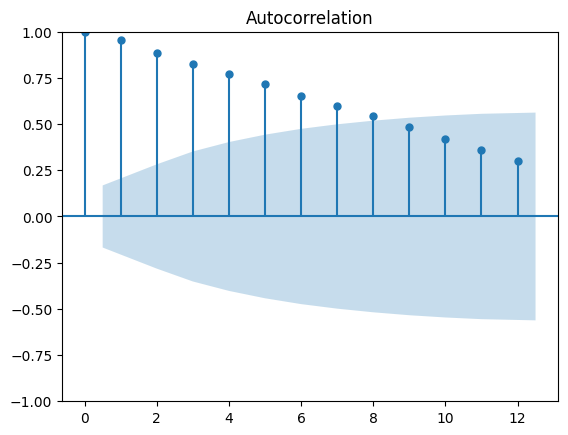

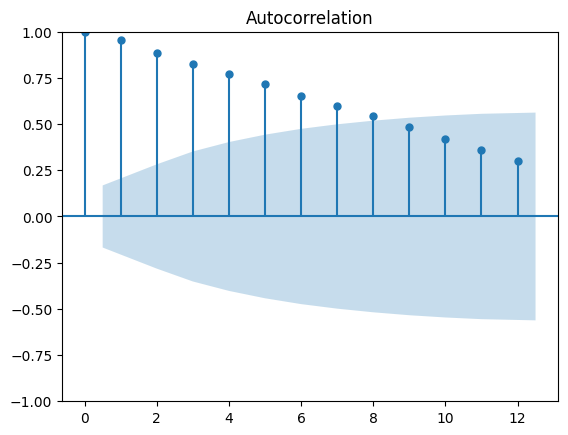

In [11]:
ADF_result = adfuller(df.Precio)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

plot_acf(df.Precio, lags=12) # Vemos como hay una relación linela en las muestras y por tanto, es no estacionario. Dentro del confidence interval se considera que es como tener 

ADF Statistic: 0.009352999999999945
p-value: 0.029034000000000004
ADF Statistic: -3.4934137634895404
p-value: 0.008157862471342342


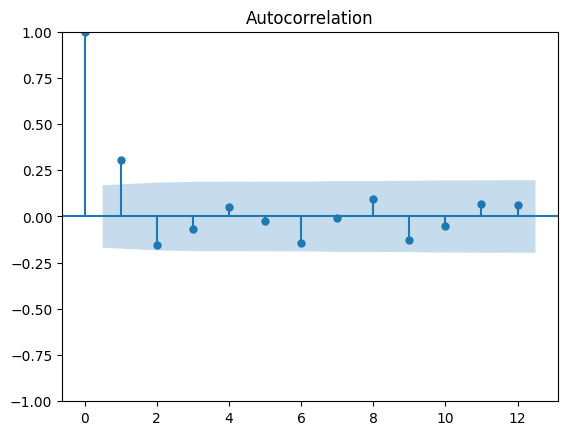

In [12]:

# Como el p valor es 0.79 y es mayor que 0.05, no podemos rechazar la null hyphotesis y por tanto es no estacionacionaria. Por ende, tennemos que diferenciar.
diff_gasolina = np.diff(df['Precio'], n = 1)
print(f'ADF Statistic: {diff_gasolina[0]}')
print(f'p-value: {diff_gasolina[1]}')
plot_acf(diff_gasolina, lags = 12) # Vemos como tenemos coeficientes significativos después de 0, esto q  uiere decir que es un random walk claramente

ADF_result = adfuller(diff_gasolina)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

### Moving Average (MA)

In [13]:
df_aux = df.copy()
df_aux = df_aux.set_index('Fecha')
indices_diff = df_aux[1:].index.tolist()

df_diff = pd.DataFrame({'diff_gasolina': diff_gasolina})
df_diff.index = indices_diff

mod = ARIMA(df_diff, order=(0,0,1))
res = mod.fit()

predict = res.get_prediction(start = '2023-05-01', end = '2023-12-01')
prediction = pd.DataFrame( columns=['predicted_MA'])


/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



### <mark>`len(df) - 1`</mark> se pone ya que cuando diferenciamos, el primer elemento se pierde, y por tanto, no podemos considerar el primer elemento que se encuentra en el lag 0

In [16]:
df_pred =pd.DataFrame({'Fecha':predict.predicted_mean.index, 'Precio':predict.predicted_mean.values})
df_total = pd.concat([df, df_pred])
df_total = df_total.reset_index(drop=True)

df_total['Precio'].loc[(len(df)-1):,] = df_total['Precio'][(len(df)-1):].cumsum()


fig = make_subplots(rows=1, cols=1)


train =df_total.loc[:(len(df)-1)]
prediction = df_total.loc[(len(df)-1):]
prediction

fig.add_trace(
    go.Line(x = train.Fecha, y = train.Precio),
    row=
    1, col=1
)
fig.add_trace(
    go.Line(x = prediction.Fecha, y = prediction.Precio),
    row=
    1, col=1
)
fig.show()



/var/folders/d6/v21thjxj31171pb2wnhhcc9c0000gn/T/ipykernel_5543/3376409595.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/amm/Documents/miniconda3/envs/gasolina/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### Calculate the error with the predictions made

In [14]:
len(df)

136

In [17]:
df_total

,Fecha,Precio
0,2012-01-01,1.433129
1,2012-02-01,1.442482
2,2012-03-01,1.471516
3,2012-04-01,1.500266
4,2012-05-01,1.455064
...,...,...
139,2023-08-01,1.652719
140,2023-09-01,1.654304
141,2023-10-01,1.655889
142,2023-11-01,1.657474


## MSE

- El <mark>len(df)</mark> del modelo con el que hemos construido el MA es en este momento <mark>136</mark>, por ello, para calcular el error compararemos hasta ese número